## 1. Setup and Imports

In [1]:
import os
import sys
import shutil
import zipfile
import random
import json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import yaml
import requests
import gdown

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Project Root: {PROJECT_ROOT}")
print("✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
✅ Imports successful!


In [2]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
RAW_DATA_PATH = PROJECT_ROOT / "datasets" / "raw"
PROCESSED_DATA_PATH = PROJECT_ROOT / "datasets" / "processed"
TRASHNET_PATH = RAW_DATA_PATH / "trashnet"
TACO_PATH = RAW_DATA_PATH / "taco"

# Data split ratios
TRAIN_SPLIT = config['dataset']['train_split']
VAL_SPLIT = config['dataset']['val_split']
TEST_SPLIT = config['dataset']['test_split']

print(f"📁 Raw Data Path: {RAW_DATA_PATH}")
print(f"📁 Processed Data Path: {PROCESSED_DATA_PATH}")
print(f"\n📊 Data Split: Train={TRAIN_SPLIT*100}%, Val={VAL_SPLIT*100}%, Test={TEST_SPLIT*100}%")

📁 Raw Data Path: c:\Users\anike\Downloads\WasteSegregation\datasets\raw
📁 Processed Data Path: c:\Users\anike\Downloads\WasteSegregation\datasets\processed

📊 Data Split: Train=70.0%, Val=15.0%, Test=15.0%


## 2. Download Datasets

### 2.1 TrashNet Dataset
TrashNet contains 2,527 images of garbage items in 6 categories.

In [3]:
def download_file(url, destination, desc="Downloading"):
    """Download a file with progress bar."""
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(destination, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=desc) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
    return destination

def extract_zip(zip_path, extract_to):
    """Extract a zip file."""
    print(f"📦 Extracting {zip_path.name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted to {extract_to}")

In [4]:
# Download TrashNet dataset from GitHub
# Original source: https://github.com/garythung/trashnet

TRASHNET_URL = "https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip"
trashnet_zip = TRASHNET_PATH / "dataset-resized.zip"

# Create directory if not exists
TRASHNET_PATH.mkdir(parents=True, exist_ok=True)

# Check if already downloaded
trashnet_data_dir = TRASHNET_PATH / "dataset-resized"
if trashnet_data_dir.exists() and any(trashnet_data_dir.iterdir()):
    print("✅ TrashNet dataset already exists, skipping download.")
else:
    print("📥 Downloading TrashNet dataset...")
    try:
        download_file(TRASHNET_URL, trashnet_zip, "TrashNet")
        extract_zip(trashnet_zip, TRASHNET_PATH)
        # Clean up zip file
        trashnet_zip.unlink()
        print("✅ TrashNet download complete!")
    except Exception as e:
        print(f"❌ Error downloading TrashNet: {e}")
        print("\n📋 Manual download instructions:")
        print("1. Go to: https://github.com/garythung/trashnet")
        print("2. Download the dataset-resized.zip from the data folder")
        print(f"3. Extract to: {TRASHNET_PATH}")

📥 Downloading TrashNet dataset...


TrashNet: 100%|██████████| 42.8M/42.8M [00:45<00:00, 943kB/s] 


📦 Extracting dataset-resized.zip...
✅ Extracted to c:\Users\anike\Downloads\WasteSegregation\datasets\raw\trashnet
✅ TrashNet download complete!


In [5]:
# Explore TrashNet dataset structure
trashnet_data_dir = TRASHNET_PATH / "dataset-resized"

if trashnet_data_dir.exists():
    print("📂 TrashNet Dataset Structure:\n")
    
    trashnet_categories = {}
    for category_dir in sorted(trashnet_data_dir.iterdir()):
        if category_dir.is_dir():
            images = list(category_dir.glob("*.jpg")) + list(category_dir.glob("*.png"))
            trashnet_categories[category_dir.name] = len(images)
            print(f"   📁 {category_dir.name}: {len(images)} images")
    
    total_images = sum(trashnet_categories.values())
    print(f"\n   📊 Total: {total_images} images")
else:
    print("❌ TrashNet dataset not found. Please download manually.")

📂 TrashNet Dataset Structure:

   📁 cardboard: 403 images
   📁 glass: 501 images
   📁 metal: 410 images
   📁 paper: 594 images
   📁 plastic: 482 images
   📁 trash: 137 images

   📊 Total: 2527 images


### 2.2 TACO Dataset
TACO (Trash Annotations in Context) contains images with bounding box annotations for object detection.

In [6]:
# TACO dataset setup
# TACO is hosted on GitHub and requires cloning the repo

TACO_PATH.mkdir(parents=True, exist_ok=True)

# Check if TACO already exists
taco_annotations = TACO_PATH / "annotations.json"

if taco_annotations.exists():
    print("✅ TACO dataset already exists, skipping download.")
else:
    print("📥 Setting up TACO dataset...")
    print("\n📋 TACO requires manual setup due to its size:")
    print("\n   Option 1 - Clone the repository:")
    print("   git clone https://github.com/pedropro/TACO.git")
    print(f"   Then copy the data folder contents to: {TACO_PATH}")
    print("\n   Option 2 - Download from Kaggle:")
    print("   https://www.kaggle.com/datasets/kneroma/tacotrashdataset")
    print(f"   Extract to: {TACO_PATH}")
    print("\n⚠️ For this project, we'll primarily use TrashNet and create synthetic bounding boxes.")

📥 Setting up TACO dataset...

📋 TACO requires manual setup due to its size:

   Option 1 - Clone the repository:
   git clone https://github.com/pedropro/TACO.git
   Then copy the data folder contents to: c:\Users\anike\Downloads\WasteSegregation\datasets\raw\taco

   Option 2 - Download from Kaggle:
   https://www.kaggle.com/datasets/kneroma/tacotrashdataset
   Extract to: c:\Users\anike\Downloads\WasteSegregation\datasets\raw\taco

⚠️ For this project, we'll primarily use TrashNet and create synthetic bounding boxes.


## 3. Data Preprocessing & Category Mapping

In [7]:
# Define category mapping from TrashNet to our classification scheme
CATEGORY_MAPPING = {
    'cardboard': 'recyclable',
    'glass': 'recyclable',
    'metal': 'recyclable',
    'paper': 'recyclable',
    'plastic': 'recyclable',
    'trash': 'general'
}

# Our target categories
TARGET_CATEGORIES = ['recyclable', 'organic', 'e-waste', 'general']

# Category to index mapping
CATEGORY_TO_IDX = {cat: idx for idx, cat in enumerate(TARGET_CATEGORIES)}
IDX_TO_CATEGORY = {idx: cat for cat, idx in CATEGORY_TO_IDX.items()}

print("📋 Category Mapping:")
print("=" * 40)
for original, mapped in CATEGORY_MAPPING.items():
    print(f"   {original:12} → {mapped}")

print("\n📋 Target Categories:")
for idx, cat in IDX_TO_CATEGORY.items():
    print(f"   {idx}: {cat}")

📋 Category Mapping:
   cardboard    → recyclable
   glass        → recyclable
   metal        → recyclable
   paper        → recyclable
   plastic      → recyclable
   trash        → general

📋 Target Categories:
   0: recyclable
   1: organic
   2: e-waste
   3: general


In [8]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess a single image.
    
    Args:
        image_path: Path to the image file
        target_size: Target size (height, width)
        
    Returns:
        Preprocessed image as numpy array
    """
    try:
        # Read image
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize
        img = cv2.resize(img, target_size)
        
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def create_yolo_annotation(image_path, output_path):
    """
    Create YOLO format annotation for an image.
    Since TrashNet images contain single centered objects,
    we create a bounding box covering the central region.
    
    YOLO format: class_id x_center y_center width height (normalized 0-1)
    """
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return False
        
        h, w = img.shape[:2]
        
        # For TrashNet, objects are typically centered
        # Create a bounding box covering ~80% of the image center
        x_center = 0.5
        y_center = 0.5
        box_width = 0.8
        box_height = 0.8
        
        # Class 0 for 'waste' (single detection class)
        annotation = f"0 {x_center} {y_center} {box_width} {box_height}\n"
        
        with open(output_path, 'w') as f:
            f.write(annotation)
        
        return True
    except Exception as e:
        print(f"Error creating annotation for {image_path}: {e}")
        return False

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


## 4. Create Train/Val/Test Splits

In [9]:
def collect_all_images(trashnet_path):
    """
    Collect all images from TrashNet dataset with their labels.
    
    Returns:
        List of tuples: (image_path, original_category, mapped_category)
    """
    all_images = []
    data_dir = trashnet_path / "dataset-resized"
    
    if not data_dir.exists():
        print(f"❌ Dataset directory not found: {data_dir}")
        return all_images
    
    for category_dir in data_dir.iterdir():
        if category_dir.is_dir():
            original_category = category_dir.name
            mapped_category = CATEGORY_MAPPING.get(original_category, 'general')
            
            for img_path in category_dir.glob("*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    all_images.append((img_path, original_category, mapped_category))
    
    return all_images

# Collect all images
all_images = collect_all_images(TRASHNET_PATH)
print(f"📊 Total images collected: {len(all_images)}")

# Show distribution
original_dist = Counter([img[1] for img in all_images])
mapped_dist = Counter([img[2] for img in all_images])

print("\n📊 Original Category Distribution:")
for cat, count in sorted(original_dist.items()):
    print(f"   {cat}: {count}")

print("\n📊 Mapped Category Distribution:")
for cat, count in sorted(mapped_dist.items()):
    print(f"   {cat}: {count}")

📊 Total images collected: 2527

📊 Original Category Distribution:
   cardboard: 403
   glass: 501
   metal: 410
   paper: 594
   plastic: 482
   trash: 137

📊 Mapped Category Distribution:
   general: 137
   recyclable: 2390


In [10]:
def split_dataset(images, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split dataset into train, validation, and test sets.
    Maintains category distribution (stratified split).
    """
    # Group by mapped category
    category_images = {}
    for img_data in images:
        category = img_data[2]  # mapped category
        if category not in category_images:
            category_images[category] = []
        category_images[category].append(img_data)
    
    train_set = []
    val_set = []
    test_set = []
    
    for category, cat_images in category_images.items():
        # Shuffle
        random.shuffle(cat_images)
        
        n = len(cat_images)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)
        
        train_set.extend(cat_images[:train_end])
        val_set.extend(cat_images[train_end:val_end])
        test_set.extend(cat_images[val_end:])
    
    # Shuffle final sets
    random.shuffle(train_set)
    random.shuffle(val_set)
    random.shuffle(test_set)
    
    return train_set, val_set, test_set

# Split the dataset
train_images, val_images, test_images = split_dataset(
    all_images, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT
)

print(f"📊 Dataset Split:")
print(f"   Train: {len(train_images)} images ({len(train_images)/len(all_images)*100:.1f}%)")
print(f"   Val:   {len(val_images)} images ({len(val_images)/len(all_images)*100:.1f}%)")
print(f"   Test:  {len(test_images)} images ({len(test_images)/len(all_images)*100:.1f}%)")

📊 Dataset Split:
   Train: 1768 images (70.0%)
   Val:   378 images (15.0%)
   Test:  381 images (15.1%)


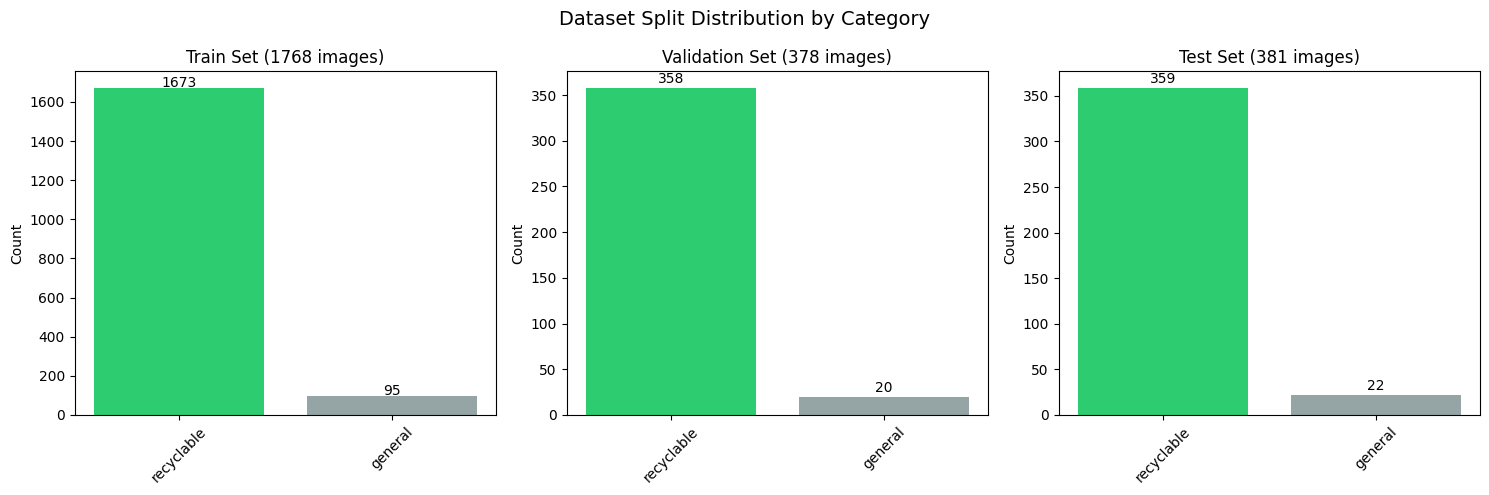

In [11]:
# Visualize the split distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = [
    ('Train', train_images),
    ('Validation', val_images),
    ('Test', test_images)
]

colors = {'recyclable': '#2ecc71', 'organic': '#f39c12', 'e-waste': '#e74c3c', 'general': '#95a5a6'}

for ax, (name, images) in zip(axes, splits):
    dist = Counter([img[2] for img in images])
    categories = list(dist.keys())
    counts = list(dist.values())
    bar_colors = [colors.get(cat, '#3498db') for cat in categories]
    
    ax.bar(categories, counts, color=bar_colors)
    ax.set_title(f'{name} Set ({len(images)} images)')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for i, (cat, count) in enumerate(zip(categories, counts)):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10)

plt.suptitle('Dataset Split Distribution by Category', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Process and Save Dataset

In [12]:
def process_and_save_split(image_list, split_name, processed_path, yolo_size=640, classifier_size=224):
    """
    Process images and save to the appropriate directories.
    Creates both YOLO format (detection) and classification format data.
    """
    images_dir = processed_path / split_name / "images"
    labels_dir = processed_path / split_name / "labels"
    
    # Create directories
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    
    # Track classification labels
    classification_data = []
    
    print(f"\n📁 Processing {split_name} set...")
    
    for img_path, original_cat, mapped_cat in tqdm(image_list, desc=f"{split_name}"):
        try:
            # Read and validate image
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            # Generate unique filename
            new_filename = f"{original_cat}_{img_path.stem}"
            
            # Save resized image for YOLO (640x640)
            img_resized = cv2.resize(img, (yolo_size, yolo_size))
            img_save_path = images_dir / f"{new_filename}.jpg"
            cv2.imwrite(str(img_save_path), img_resized)
            
            # Create YOLO annotation
            label_save_path = labels_dir / f"{new_filename}.txt"
            create_yolo_annotation(img_path, label_save_path)
            
            # Store classification data
            classification_data.append({
                'filename': f"{new_filename}.jpg",
                'original_category': original_cat,
                'category': mapped_cat,
                'category_idx': CATEGORY_TO_IDX[mapped_cat]
            })
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    # Save classification CSV
    df = pd.DataFrame(classification_data)
    csv_path = processed_path / split_name / "labels.csv"
    df.to_csv(csv_path, index=False)
    
    print(f"✅ {split_name}: Saved {len(classification_data)} images")
    print(f"   📄 Labels CSV: {csv_path}")
    
    return df

In [13]:
# Process all splits
print("🔄 Processing dataset splits...")
print("=" * 50)

yolo_size = config['dataset']['yolo_image_size']
classifier_size = config['dataset']['image_size']

train_df = process_and_save_split(train_images, "train", PROCESSED_DATA_PATH, yolo_size, classifier_size)
val_df = process_and_save_split(val_images, "val", PROCESSED_DATA_PATH, yolo_size, classifier_size)
test_df = process_and_save_split(test_images, "test", PROCESSED_DATA_PATH, yolo_size, classifier_size)

print("\n" + "=" * 50)
print("✅ Dataset processing complete!")

🔄 Processing dataset splits...

📁 Processing train set...


train: 100%|██████████| 1768/1768 [00:42<00:00, 41.50it/s]


✅ train: Saved 1768 images
   📄 Labels CSV: c:\Users\anike\Downloads\WasteSegregation\datasets\processed\train\labels.csv

📁 Processing val set...


val: 100%|██████████| 378/378 [00:09<00:00, 39.16it/s]


✅ val: Saved 378 images
   📄 Labels CSV: c:\Users\anike\Downloads\WasteSegregation\datasets\processed\val\labels.csv

📁 Processing test set...


test: 100%|██████████| 381/381 [00:09<00:00, 39.55it/s]

✅ test: Saved 381 images
   📄 Labels CSV: c:\Users\anike\Downloads\WasteSegregation\datasets\processed\test\labels.csv

✅ Dataset processing complete!


## 6. Create Classification Dataset (for MobileNet)

In [14]:
# Create category subdirectories for classification training
# This structure works well with Keras ImageDataGenerator

def create_classification_structure(processed_path, split_name, df, source_images_dir):
    """
    Create category-based directory structure for classification.
    Structure: processed/split_name/classification/category_name/images
    """
    classification_dir = processed_path / split_name / "classification"
    
    # Create category directories
    for category in TARGET_CATEGORIES:
        (classification_dir / category).mkdir(parents=True, exist_ok=True)
    
    # Copy/resize images to category folders
    classifier_size = config['dataset']['image_size']
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"{split_name} classification"):
        src_path = source_images_dir / row['filename']
        dst_path = classification_dir / row['category'] / row['filename']
        
        if src_path.exists():
            # Read, resize to classifier size, and save
            img = cv2.imread(str(src_path))
            img_resized = cv2.resize(img, (classifier_size, classifier_size))
            cv2.imwrite(str(dst_path), img_resized)
    
    print(f"✅ Created classification structure for {split_name}")
    return classification_dir

# Create classification directories for each split
print("\n📁 Creating classification directory structure...")
create_classification_structure(PROCESSED_DATA_PATH, "train", train_df, PROCESSED_DATA_PATH / "train" / "images")
create_classification_structure(PROCESSED_DATA_PATH, "val", val_df, PROCESSED_DATA_PATH / "val" / "images")
create_classification_structure(PROCESSED_DATA_PATH, "test", test_df, PROCESSED_DATA_PATH / "test" / "images")


📁 Creating classification directory structure...


train classification: 100%|██████████| 1768/1768 [00:39<00:00, 44.55it/s]


✅ Created classification structure for train


val classification: 100%|██████████| 378/378 [00:09<00:00, 41.29it/s]


✅ Created classification structure for val


test classification: 100%|██████████| 381/381 [00:09<00:00, 41.56it/s]

✅ Created classification structure for test


WindowsPath('c:/Users/anike/Downloads/WasteSegregation/datasets/processed/test/classification')

## 7. Visualize Sample Images

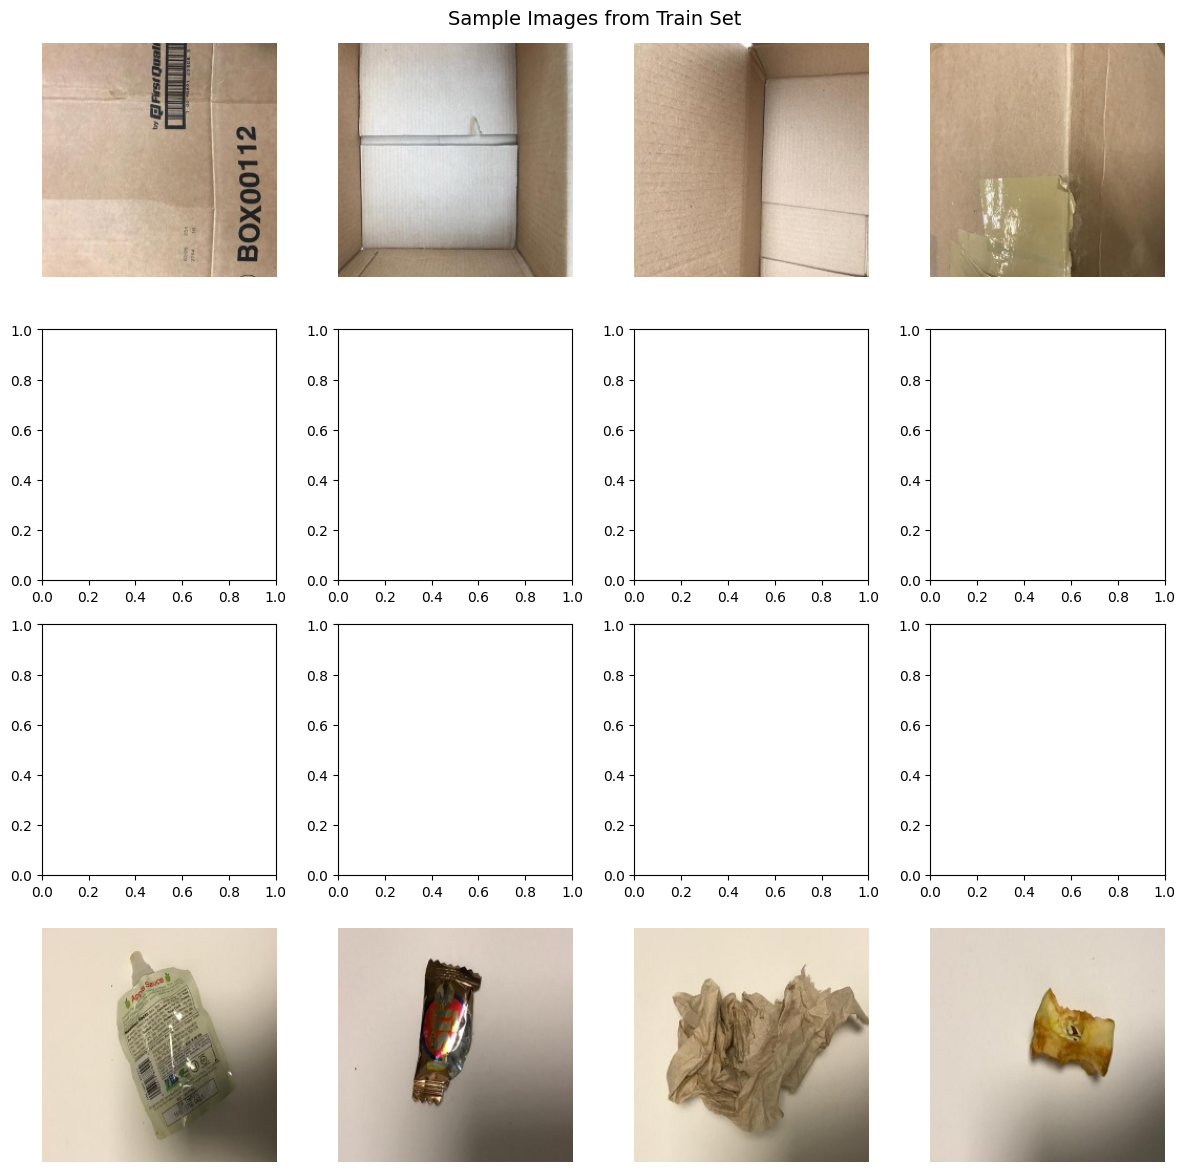

In [15]:
# Display sample images from each category
def show_sample_images(processed_path, split="train", samples_per_category=3):
    """
    Display sample images from each category.
    """
    classification_dir = processed_path / split / "classification"
    
    fig, axes = plt.subplots(len(TARGET_CATEGORIES), samples_per_category, figsize=(12, 12))
    
    for row, category in enumerate(TARGET_CATEGORIES):
        category_dir = classification_dir / category
        if category_dir.exists():
            images = list(category_dir.glob("*.jpg"))[:samples_per_category]
            
            for col, img_path in enumerate(images):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                ax = axes[row, col] if len(TARGET_CATEGORIES) > 1 else axes[col]
                ax.imshow(img)
                ax.axis('off')
                if col == 0:
                    ax.set_ylabel(category, fontsize=12, rotation=0, ha='right', va='center')
        else:
            for col in range(samples_per_category):
                ax = axes[row, col] if len(TARGET_CATEGORIES) > 1 else axes[col]
                ax.text(0.5, 0.5, 'No images', ha='center', va='center')
                ax.axis('off')
    
    plt.suptitle(f'Sample Images from {split.capitalize()} Set', fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(PROCESSED_DATA_PATH, "train", 4)

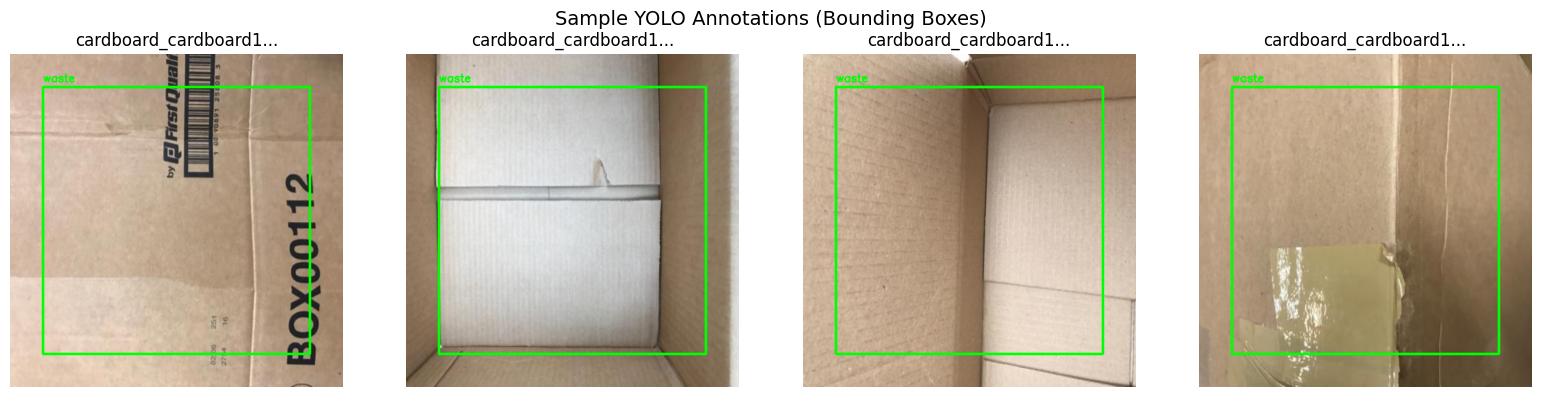

In [16]:
# Show sample with bounding box annotation
def show_yolo_annotations(processed_path, split="train", num_samples=4):
    """
    Display images with their YOLO bounding box annotations.
    """
    images_dir = processed_path / split / "images"
    labels_dir = processed_path / split / "labels"
    
    image_files = list(images_dir.glob("*.jpg"))[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))
    
    for ax, img_path in zip(axes, image_files):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load annotation
        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                line = f.readline().strip()
                parts = line.split()
                if len(parts) == 5:
                    cls, x_c, y_c, bw, bh = map(float, parts)
                    
                    # Convert normalized coords to pixels
                    x1 = int((x_c - bw/2) * w)
                    y1 = int((y_c - bh/2) * h)
                    x2 = int((x_c + bw/2) * w)
                    y2 = int((y_c + bh/2) * h)
                    
                    # Draw bounding box
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    cv2.putText(img, 'waste', (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_path.stem[:20] + '...')
    
    plt.suptitle('Sample YOLO Annotations (Bounding Boxes)', fontsize=14)
    plt.tight_layout()
    plt.show()

show_yolo_annotations(PROCESSED_DATA_PATH, "train", 4)

## 8. Dataset Statistics Summary

In [17]:
# Generate comprehensive dataset statistics
def generate_dataset_report(processed_path):
    """
    Generate a comprehensive report of the processed dataset.
    """
    print("=" * 60)
    print("📊 DATASET STATISTICS REPORT")
    print("=" * 60)
    
    splits = ['train', 'val', 'test']
    total_stats = {'images': 0, 'labels': 0}
    category_totals = Counter()
    
    for split in splits:
        csv_path = processed_path / split / "labels.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            images_count = len(df)
            
            print(f"\n📁 {split.upper()} SET:")
            print(f"   Total images: {images_count}")
            
            dist = df['category'].value_counts()
            for cat, count in dist.items():
                print(f"   • {cat}: {count} ({count/images_count*100:.1f}%)")
                category_totals[cat] += count
            
            total_stats['images'] += images_count
    
    print("\n" + "=" * 60)
    print(f"📊 TOTAL DATASET: {total_stats['images']} images")
    print("=" * 60)
    for cat, count in category_totals.items():
        print(f"   • {cat}: {count} ({count/total_stats['images']*100:.1f}%)")
    
    return total_stats, category_totals

stats, cat_totals = generate_dataset_report(PROCESSED_DATA_PATH)

📊 DATASET STATISTICS REPORT

📁 TRAIN SET:
   Total images: 1768
   • recyclable: 1673 (94.6%)
   • general: 95 (5.4%)

📁 VAL SET:
   Total images: 378
   • recyclable: 358 (94.7%)
   • general: 20 (5.3%)

📁 TEST SET:
   Total images: 381
   • recyclable: 359 (94.2%)
   • general: 22 (5.8%)

📊 TOTAL DATASET: 2527 images
   • recyclable: 2390 (94.6%)
   • general: 137 (5.4%)


In [18]:
# Save dataset metadata
metadata = {
    'dataset_info': {
        'source': 'TrashNet',
        'total_images': stats['images'],
        'image_size_yolo': config['dataset']['yolo_image_size'],
        'image_size_classifier': config['dataset']['image_size'],
        'splits': {
            'train': len(train_df),
            'val': len(val_df),
            'test': len(test_df)
        }
    },
    'categories': TARGET_CATEGORIES,
    'category_mapping': CATEGORY_MAPPING,
    'category_to_idx': CATEGORY_TO_IDX
}

metadata_path = PROCESSED_DATA_PATH / "metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata saved to: {metadata_path}")

✅ Metadata saved to: c:\Users\anike\Downloads\WasteSegregation\datasets\processed\metadata.json


## 9. Verify YOLO Dataset Configuration

In [19]:
# Update and verify YOLO dataset.yaml
yolo_dataset_config = {
    'path': str(PROCESSED_DATA_PATH),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': 1,  # Number of classes (single 'waste' class for detection)
    'names': ['waste']
}

yolo_yaml_path = PROJECT_ROOT / "config" / "dataset.yaml"
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(yolo_dataset_config, f, default_flow_style=False)

print("📄 YOLO Dataset Configuration:")
print("=" * 40)
with open(yolo_yaml_path, 'r') as f:
    print(f.read())

📄 YOLO Dataset Configuration:
names:
- waste
nc: 1
path: c:\Users\anike\Downloads\WasteSegregation\datasets\processed
test: test/images
train: train/images
val: val/images



## 10. Phase 2 Summary

In [20]:
print("=" * 60)
print("🎉 PHASE 2 COMPLETE: DATA ACQUISITION & PREPARATION")
print("=" * 60)

print("\n📦 DATASETS PROCESSED:")
print(f"   • TrashNet: {stats['images']} images")

print("\n📁 OUTPUT STRUCTURE:")
print(f"   {PROCESSED_DATA_PATH}/")
print("   ├── train/")
print("   │   ├── images/          (YOLO format, 640x640)")
print("   │   ├── labels/          (YOLO annotations)")
print("   │   ├── classification/  (Category folders, 224x224)")
print("   │   └── labels.csv")
print("   ├── val/")
print("   │   └── (same structure)")
print("   ├── test/")
print("   │   └── (same structure)")
print("   └── metadata.json")

print("\n📊 DATA SPLIT:")
print(f"   • Train: {len(train_df)} images")
print(f"   • Val:   {len(val_df)} images")
print(f"   • Test:  {len(test_df)} images")

print("\n🏷️ CATEGORIES:")
for cat, count in cat_totals.items():
    print(f"   • {cat}: {count} images")

print("\n✅ NEXT STEPS:")
print("   1. Phase 3: Train YOLO object detection model")
print("   2. Phase 4: Train MobileNet classification model")
print("   3. Phase 5: Train Autoencoder for anomaly detection")

print("\n" + "=" * 60)

🎉 PHASE 2 COMPLETE: DATA ACQUISITION & PREPARATION

📦 DATASETS PROCESSED:
   • TrashNet: 2527 images

📁 OUTPUT STRUCTURE:
   c:\Users\anike\Downloads\WasteSegregation\datasets\processed/
   ├── train/
   │   ├── images/          (YOLO format, 640x640)
   │   ├── labels/          (YOLO annotations)
   │   ├── classification/  (Category folders, 224x224)
   │   └── labels.csv
   ├── val/
   │   └── (same structure)
   ├── test/
   │   └── (same structure)
   └── metadata.json

📊 DATA SPLIT:
   • Train: 1768 images
   • Val:   378 images
   • Test:  381 images

🏷️ CATEGORIES:
   • recyclable: 2390 images
   • general: 137 images

✅ NEXT STEPS:
   1. Phase 3: Train YOLO object detection model
   2. Phase 4: Train MobileNet classification model
   3. Phase 5: Train Autoencoder for anomaly detection

